# Imports and define functions

## Imports
    Imports all modules and submodules that were necessary for this study.
    Special mention to TimeSeriesCrossValidation which was created with the purpose to be used in this thesis (https://github.com/DidierRLopes/TimeSeriesCrossValidation).

In [1]:
import numpy as np
import pandas as pd
import pandas_datareader as dr
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import seaborn as sns
import ast

from TimeSeriesCrossValidation import splitTrain
from time import strftime
from collections import OrderedDict
from scipy.stats import skewtest, kurtosistest, skew, kurtosis
from statsmodels.tsa.stattools import adfuller, kpss, bds
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import het_arch, acorr_ljungbox, acorr_breusch_godfrey
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.gridspec as gridspec
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.filterwarnings("ignore")

## Define Functions
    Defines helper functions

In [2]:
def parse_tuple(string):
    try:
        s = ast.literal_eval(str(string))
        if type(s) == tuple:
            return s
        return
    except:
        return

In [3]:
# Compute MAE over an array of different horizons
def horizon_mae(y_true, y_pred, horizonSteps):
    ae  = abs(y_pred - y_true.T);
    list_MAE = list()
    for i in horizonSteps:
        list_MAE.append(round(np.mean(ae[0,:i]), 2))
    return list_MAE;

In [4]:
# Define Mean Absolute Percentage Error
def absolute_percentage_error(y_true, y_pred):
    if (len(y_true[y_true == 0])):
        print("Division by zero!")
        return None;
    else:
        return 100*(abs((y_pred - y_true.T) / y_true.T));

In [5]:
# Compute MAPE over an array of different horizons
def horizon_mape(y_true, y_pred, horizonSteps):
    ape = absolute_percentage_error(y_true, y_pred);
    if ape is not None:
        list_MAPE = list()
        for i in horizonSteps:
            list_MAPE.append(round(np.mean(ape[0,:i]), 2))
        return list_MAPE;

In [6]:
def replace_initial_outliers(df, numInitialSamples, valToReplace, outlierConstant):
    df_resNew = df.copy()
    upper_quartile = np.percentile(df_resNew.values, 75)
    lower_quartile = np.percentile(df_resNew.values, 25)
    
    # Interquantile Range
    IQR = (upper_quartile - lower_quartile) * outlierConstant
    lower_quartileBound = lower_quartile - IQR
    upper_quartileBound = upper_quartile + IQR
    
    outliers = []
    for ix in range(0, numInitialSamples):
        if (df_resNew.values[ix] < lower_quartileBound or df_resNew.values[ix] > upper_quartileBound):
            outliers.append((df_res.index[ix].strftime("%Y-%m-%d"), df_res.values[ix][0]))
            df_resNew.values[ix] = valToReplace
            
    return df_resNew, outliers

In [7]:
# Evaluate combinations of p, d and q values for a SARIMA model
def SARIMA_grid(dataset, sarimaCfg, isLog):
    df_IC = pd.DataFrame(columns=['SARIMA(p,d,q)t(P,D,Q,m)', 'AIC', 'BIC', 'HQIC'])
    df_IC = df_IC.set_index('SARIMA(p,d,q)t(P,D,Q,m)')
    dict_sarimaFit  = {} 
    dict_sarimaPred = {}
    modelNum = 0;
    totalModelNum = len(sarimaCfg.p_range)*len(sarimaCfg.d_range)*len(sarimaCfg.q_range)*len(sarimaCfg.t_range)* \
                        len(sarimaCfg.P_range)*len(sarimaCfg.D_range)*len(sarimaCfg.Q_range)*len(sarimaCfg.m_range)
    for p in sarimaCfg.p_range:
        for d in sarimaCfg.d_range:
            for q in sarimaCfg.q_range:
                order = (p,d,q)
                for t in sarimaCfg.t_range:
                    for P in sarimaCfg.P_range:
                        for D in sarimaCfg.D_range:
                            for Q in sarimaCfg.Q_range:
                                for m in sarimaCfg.m_range:
                                    seasonal_order = (P,D,Q,m)
                                    modelNum+=1;
                                    print("%d/%d " % (modelNum, totalModelNum))
                                     
                                    try:
                                        model = SARIMAX(dataset, order=order, \
                                                                 trend=t,     \
                                                                 seasonal_order=seasonal_order);
                                        model_fit = model.fit(disp=0);
                                        
                                        if (~np.isnan(model_fit.mle_retvals.get('fopt'))):
                                              
                                            model_str = 'SARIMA' + str(order) + str(t) + str(seasonal_order)
                                            df_IC = df_IC.append(pd.DataFrame({'AIC':model_fit.aic, 'BIC':model_fit.bic, \
                                                                               'HQIC':model_fit.hqic}, index =[model_str]), ignore_index=False)

                                            if (isLog):
                                                dict_sarimaFit[model_str]  = np.e**(model_fit.predict(typ='levels'));
                                                dict_sarimaPred[model_str] = np.e**(model_fit.forecast(steps=stepsToForecast[-1]));
                                            else:
                                                dict_sarimaFit[model_str]  = model_fit.predict(typ='levels');
                                                dict_sarimaPred[model_str] = model_fit.forecast(steps=stepsToForecast[-1]);
                                    except:
                                        continue
    return dict_sarimaFit, dict_sarimaPred, df_IC

## Define Univariate Time-Series to study
    df: Dataframe with an index and a value column
    title: Title of data being used
    serie: Serie 'Name'
    xlab: Label of df.index
    ylab: Label of df.values
    seasonal_periods: The repetition cycle
    
    stepsToForecast: Steps to forecast out-of-sample (and in-sample)

In [8]:
previousStepsToShow = 15;

stepsToForecast = [1, 3, 12]
df = dr.DataReader("TRFVOLUSM227NFWA", "fred", start="1947-01-01", end="2019-09-01")
df_train = df[['TRFVOLUSM227NFWA']][:-stepsToForecast[-1]].rename(columns={'TRFVOLUSM227NFWA': 'train'})
df_test = df[['TRFVOLUSM227NFWA']][-stepsToForecast[-1]:].rename(columns={'TRFVOLUSM227NFWA': 'test'})
title = "Vehicle Miles Traveled";
serie = "VMT"
xlab = "Months/Year";
ylab = "Miles Traveled (Millions)";
seasonal_periods = 12

# Stationarity of the Time-Series

## Data transformation and its graphical representation
    This section allows to understand the representation of the series after its transformation to achieve stationarity

    Box-Cox transformations such as the logarithmic one can help to stabilise the variance of a time series. 
    Differencing can help stabilise the mean of a time series by removing changes in the level of a time series, and therefore eliminating (or reducing) trend and seasonality.
    Note: The order Box-Cox transformation, and then, differencing, is important!

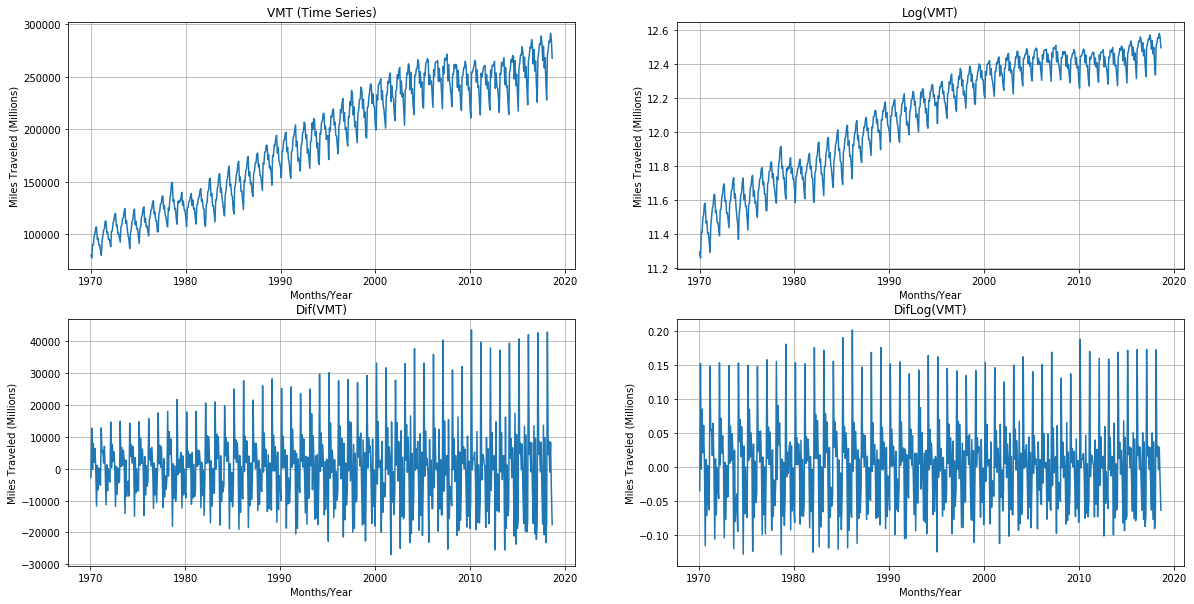

In [9]:
fig = plt.figure(figsize=(20,10))

fig.add_subplot(221)
plt.title(serie + ' (Time Series)')
plt.plot(df_train)
plt.xlabel(xlab)
plt.ylabel(ylab)
plt.grid()

fig.add_subplot(222)
plt.title('Log(' + serie + ')')
plt.plot(np.log(df_train))
plt.xlabel(xlab)
plt.ylabel(ylab)
plt.grid()

fig.add_subplot(223)
plt.title('Dif(' + serie + ')')
plt.plot(df_train.diff().dropna())
plt.xlabel(xlab)
plt.ylabel(ylab)
plt.grid()

fig.add_subplot(224)
plt.title('DifLog(' + serie + ')')
plt.plot(np.log(df_train).diff().dropna())
plt.xlabel(xlab)
plt.ylabel(ylab)
plt.grid()

plt.show()

## Normality tests

### Jarque-Bera 
    Perform the Jarque-Bera goodness of fit test on sample data.
    The Jarque-Bera test tests whether the sample data has the skewness and kurtosis matching a normal distribution.

In [10]:
jb, jbpval = stats.jarque_bera(df_train)
print("Jarque-Bera Test for " + serie)
print("Statistic: %.4f" % jb)
print("p-value: %.4f" % jbpval)
print("")
jb, jbpval = stats.jarque_bera(np.log(df_train))
print("Jarque-Bera Test for Log(" + serie + ")")
print("Statistic: %.4f" % jb)
print("p-value: %.4f" % jbpval)
print("")
jb, jbpval = stats.jarque_bera(df_train.diff().dropna())
print("Jarque-Bera Test for Diff(" + serie + ")")
print("Statistic: %.4f" % jb)
print("p-value: %.4f" % jbpval)
print("")
jb, jbpval = stats.jarque_bera(np.log(df_train).diff().dropna())
print("Jarque-Bera Test for Diff(Log(" + serie + "))")
print("Statistic: %.4f" % jb)
print("p-value: %.4f" % jbpval) 
print("")

Jarque-Bera Test for VMT
Statistic: 46.3470
p-value: 0.0000

Jarque-Bera Test for Log(VMT)
Statistic: 49.2307
p-value: 0.0000

Jarque-Bera Test for Diff(VMT)
Statistic: 72.2982
p-value: 0.0000

Jarque-Bera Test for Diff(Log(VMT))
Statistic: 41.1355
p-value: 0.0000



### Kolmogorov-Smirnov
    Perform the Kolmogorov-Smirnov test for goodness of fit.
    This performs a test of the distribution G(x) of an observed random variable against a given distribution F(x). Under the null hypothesis the two distributions are identical, G(x)=F(x). The alternative hypothesis can be either 'two-sided' (default), 'less' or 'greater'. The KS test is only valid for continuous distributions.

In [11]:
# Kolmogorov-Smirnov Test goodness of fit test on sample data
ks, kspval = stats.kstest(df_train.values, 'norm')
print("Kolmogorov-Smirnov Test for " + serie)
print("Statistic: %.4f" % ks)
print("p-value: %.4f" % kspval)  
print("")
ks, kspval = stats.kstest(np.log(df_train), 'norm')
print("Kolmogorov-Smirnov Test for Log(" + serie + ")")
print("Statistic: %.4f" % ks)
print("p-value: %.4f" % kspval)
print("")
ks, kspval = stats.kstest(df_train.diff().dropna(), 'norm')
print("Kolmogorov-Smirnov Test for Diff(" + serie + ")")
print("Statistic: %.4f" % ks)
print("p-value: %.4f" % kspval)
print("")
ks, kspval = stats.kstest(np.log(df_train).diff().dropna(), 'norm')
print("Kolmogorov-Smirnov Test for Diff(Log(" + serie + "))")
print("Statistic: %.4f" % ks)
print("p-value: %.4f" % kspval) 
print("")

Kolmogorov-Smirnov Test for VMT
Statistic: 1.0000
p-value: 0.0000

Kolmogorov-Smirnov Test for Log(VMT)
Statistic: 1.0000
p-value: 0.0000

Kolmogorov-Smirnov Test for Diff(VMT)
Statistic: 1.0000
p-value: 0.0000

Kolmogorov-Smirnov Test for Diff(Log(VMT))
Statistic: 0.5801
p-value: 0.0000



## Unit Root and Stationarity Tests

### The Augmented Dickey-Fuller test 
    Augmented Dickey-Fuller unit root test.
    The Augmented Dickey-Fuller test can be used to test for a unit root in a univariate process in the presence of serial correlation.

In [12]:
# The Augmented Dickey-Fuller test 
# Used to test for a unit root in a univariate process in the presence of serial correlation.
result = adfuller(df_train['train'].values)
print("Augmented Dickey Fuller Test for " + serie)
print("Statistic: %.4f" % result[0])
print("p-value: %.4f" % result[1])
print("Used lags: %d" % result[2])
print("Num obs: %d" % result[3])
print("Critical Values:")
d = OrderedDict(sorted(result[4].items(), key=lambda t: t[1]))
for key, value in d.items():
    print("\t%s: %.3f" % (key, value))
print("")
result = adfuller(np.log(df_train['train'].values))
print("Augmented Dickey Fuller Test for Log(" + serie + ")")
print("Statistic: %.4f" % result[0])
print("p-value: %.4f" % result[1])
print("Used lags: %d" % result[2])
print("Num obs: %d" % result[3])
print("Critical Values:")
d = OrderedDict(sorted(result[4].items(), key=lambda t: t[1]))
for key, value in d.items():
    print("\t%s: %.3f" % (key, value))
print("")
result = adfuller(df_train['train'].diff().dropna())
print("Augmented Dickey Fuller Test for Diff(" + serie + ")")
print("Statistic: %.4f" % result[0])
print("p-value: %.4f" % result[1])
print("Used lags: %d" % result[2])
print("Num obs: %d" % result[3])
print("Critical Values:")
d = OrderedDict(sorted(result[4].items(), key=lambda t: t[1]))
for key, value in d.items():
    print ("\t%s: %.3f" % (key, value))
print("")
result = adfuller(np.log(df_train['train']).diff().dropna().values)
print("Augmented Dickey Fuller Test for Diff(Log(" + serie + "))")
print("Statistic: %.4f" % result[0])
print("p-value: %.4f" % result[1])
print("Used lags: %d" % result[2])
print("Num obs: %d" % result[3])
print("Critical Values:")
d = OrderedDict(sorted(result[4].items(), key=lambda t: t[1]))
for key, value in d.items():
    print("\t%s: %.3f" % (key, value))

Augmented Dickey Fuller Test for VMT
Statistic: -1.1839
p-value: 0.6805
Used lags: 17
Num obs: 567
Critical Values:
	1%: -3.442
	5%: -2.867
	10%: -2.569

Augmented Dickey Fuller Test for Log(VMT)
Statistic: -3.0600
p-value: 0.0297
Used lags: 14
Num obs: 570
Critical Values:
	1%: -3.442
	5%: -2.867
	10%: -2.569

Augmented Dickey Fuller Test for Diff(VMT)
Statistic: -4.9084
p-value: 0.0000
Used lags: 16
Num obs: 567
Critical Values:
	1%: -3.442
	5%: -2.867
	10%: -2.569

Augmented Dickey Fuller Test for Diff(Log(VMT))
Statistic: -4.7955
p-value: 0.0001
Used lags: 16
Num obs: 567
Critical Values:
	1%: -3.442
	5%: -2.867
	10%: -2.569


### Kwiatkowski-Phillips-Schmidt-Shin
    Kwiatkowski-Phillips-Schmidt-Shin test for stationarity.
    Computes the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test for the null hypothesis that x is level or trend stationary.

In [13]:
result = kpss(df_train['train'].values)
print("Kwiatkowski-Phillips-Schmidt-Shin Test for " + serie)
print("Statistic: %.4f" % result[0])
print("Critical Values:")
d = OrderedDict(sorted(result[3].items(), key=lambda t: t[1], reverse=True))
for key, value in d.items():
    print("\t%s: %.3f" % (key, value));
print("")
result = kpss(np.log(df_train['train'].values))
print("Kwiatkowski-Phillips-Schmidt-Shin Test for Log(" + serie + ")")
print("Statistic: %.4f" % result[0])
print("Critical Values:")
d = OrderedDict(sorted(result[3].items(), key=lambda t: t[1], reverse=True))
for key, value in d.items():
    print("\t%s: %.3f" % (key, value));
print("")
result = kpss(df_train['train'].diff().dropna())
print("Kwiatkowski-Phillips-Schmidt-Shin Test for Diff(" + serie + ")")
print("Statistic: %.4f" % result[0])
print("Critical Values:")
d = OrderedDict(sorted(result[3].items(), key=lambda t: t[1], reverse=True))
for key, value in d.items():
    print("\t%s: %.3f" % (key, value));
print("")
result = kpss(np.log(df_train['train']).diff().dropna().values)
print("Kwiatkowski-Phillips-Schmidt-Shin Test for Diff(Log(" + serie + "))")
print("Statistic: %.4f" % result[0])
print("Critical Values:")
d = OrderedDict(sorted(result[3].items(), key=lambda t: t[1], reverse=True))
for key, value in d.items():
    print("\t%s: %.3f" % (key, value));

Kwiatkowski-Phillips-Schmidt-Shin Test for VMT
Statistic: 3.0064
Critical Values:
	1%: 0.739
	2.5%: 0.574
	5%: 0.463
	10%: 0.347

Kwiatkowski-Phillips-Schmidt-Shin Test for Log(VMT)
Statistic: 2.9398
Critical Values:
	1%: 0.739
	2.5%: 0.574
	5%: 0.463
	10%: 0.347

Kwiatkowski-Phillips-Schmidt-Shin Test for Diff(VMT)
Statistic: 0.0367
Critical Values:
	1%: 0.739
	2.5%: 0.574
	5%: 0.463
	10%: 0.347

Kwiatkowski-Phillips-Schmidt-Shin Test for Diff(Log(VMT))
Statistic: 0.1155
Critical Values:
	1%: 0.739
	2.5%: 0.574
	5%: 0.463
	10%: 0.347


## Correlation plots
    These plots are useful for identifying non-stationary time series 

    This also gives an idea of the order of the model by:
        AR(p) - p from the partial autocorrelation plot
        I(d)  - d from the number of Diffs your dataset is using
        MA(q) - q from the autocorrelation plot

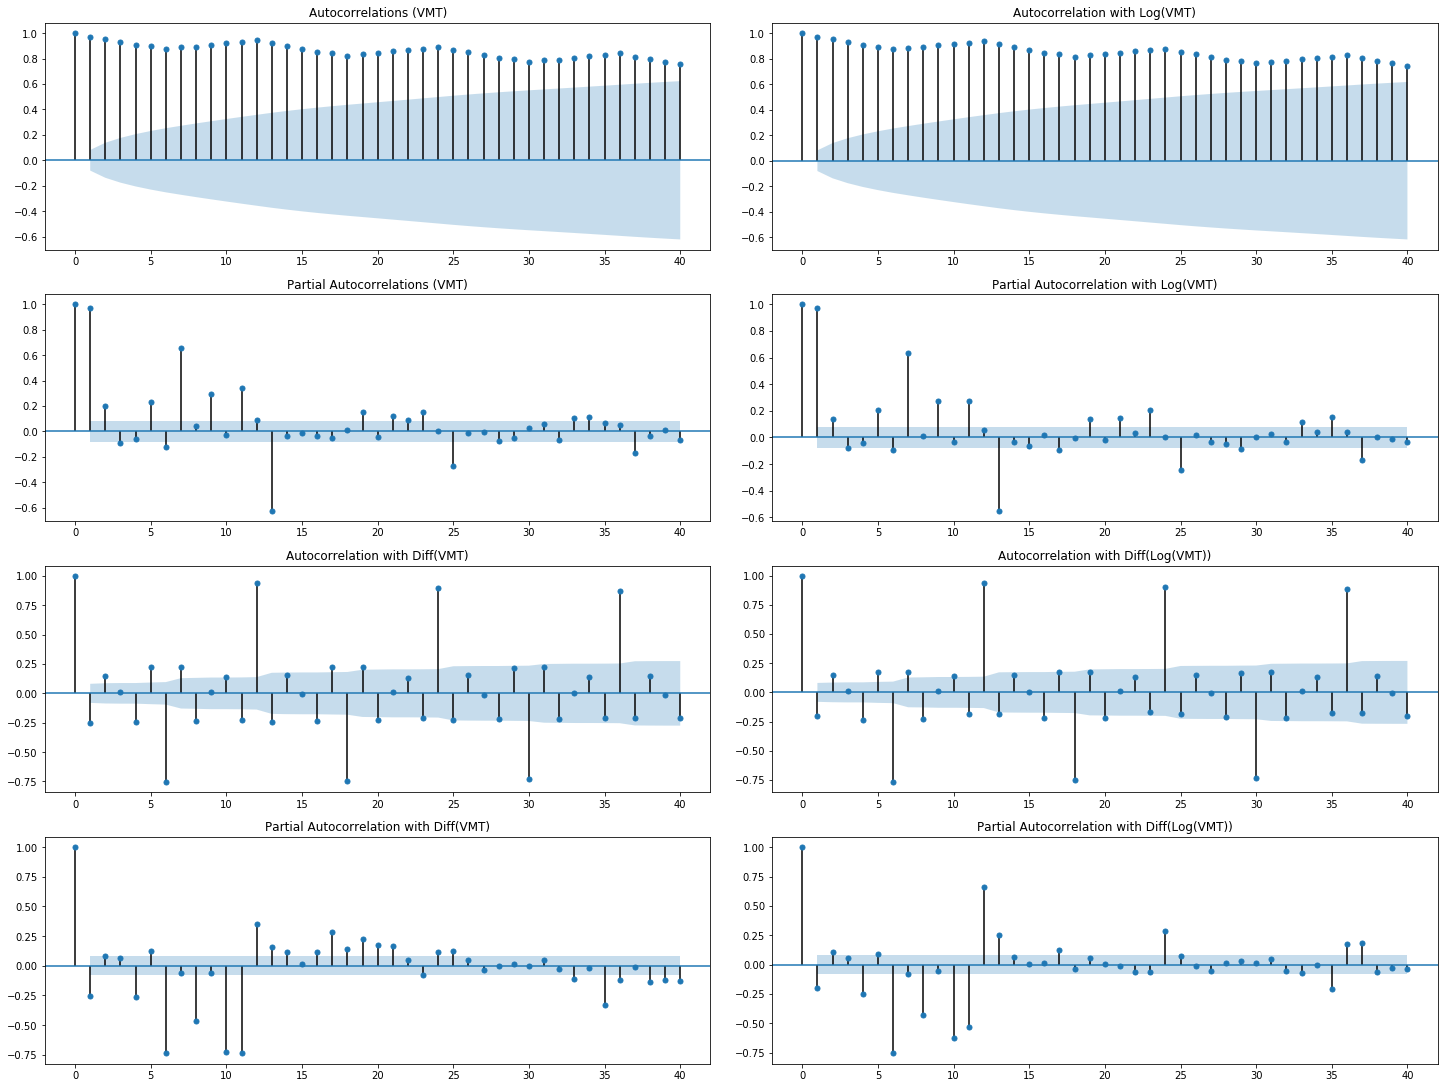

In [14]:
maxLags = 40

fig = plt.figure(figsize=(20,15), constrained_layout=True)
spec = gridspec.GridSpec(ncols=2, nrows=4, figure=fig)

# Auto-correlation function for original time series
ax_acf = fig.add_subplot(spec[0, 0])
sm.graphics.tsa.plot_acf(df_train, lags=maxLags, ax=ax_acf, title='Autocorrelations (' + serie + ')')
# Partial auto-correlation function for original time series
ax_pacf = fig.add_subplot(spec[1, 0])
sm.graphics.tsa.plot_pacf(df_train, lags=maxLags, ax=ax_pacf, title='Partial Autocorrelations (' + serie + ')');

# Auto-correlation function for time series transformed with Log
ax_acfLog = fig.add_subplot(spec[0, 1])
sm.graphics.tsa.plot_acf(np.log(df_train), lags=maxLags, ax=ax_acfLog, title='Autocorrelation with Log('+ serie + ')')
# Partial auto-correlation function for time series transformed with Log
ax_pacfLog = fig.add_subplot(spec[1, 1])
sm.graphics.tsa.plot_pacf(np.log(df_train), lags=maxLags, ax=ax_pacfLog, title='Partial Autocorrelation with Log('+ serie + ')');

# Auto-correlation function for time series transformed with Diff
ax_acfDiff = fig.add_subplot(spec[2, 0])
sm.graphics.tsa.plot_acf(df_train.diff().dropna(), lags=maxLags, ax=ax_acfDiff, title='Autocorrelation with Diff('+ serie + ')')
# Partial auto-correlation function for time series transformed with Diff
ax_pacfDiff = fig.add_subplot(spec[3, 0])
sm.graphics.tsa.plot_pacf(df_train.diff().dropna(), lags=maxLags, ax=ax_pacfDiff, title='Partial Autocorrelation with Diff('+ serie + ')');

# Auto-correlation function for time series transformed with Log
ax_acfDiffLog = fig.add_subplot(spec[2, 1])
sm.graphics.tsa.plot_acf(np.log(df_train).diff().dropna(), lags=maxLags, ax=ax_acfDiffLog, title='Autocorrelation with Diff(Log('+ serie + '))')
# Partial auto-correlation function for time series transformed with Log
ax_pacfDiffLog = fig.add_subplot(spec[3, 1])
sm.graphics.tsa.plot_pacf(np.log(df_train).diff().dropna(), lags=maxLags, ax=ax_pacfDiffLog, title='Partial Autocorrelation with Diff(Log('+ serie + '))');

plt.show()

# SARIMA Selection

## Pre-processing
    From now on, we must choose whether we go with the Log(Time-Series) or not. This should be done to remove stationarity of the data, so that SARIMA can work. In addition, if the model is multiplicative we need to use log to make it additive as SARIMA relies on that assumption. The previously seen differentiated data enters in the I component of the SARIMA model it will take care of differenciating for us.

In [15]:
isLog = True

if (isLog):
    df_Train = pd.DataFrame(np.log(df_train), index = df_train.index).copy()
else:
    df_Train = df_train.copy()

## Model training
    In this section we will train several SARIMA models based on distinct (p,d,q)t(P,D,Q)m combinations.
    Not only train but also forecast, and extract their AIC, BIC and HQIC.

In [16]:
# Range of SARIMA models to compute
class sarimaCfg:
    p_range = range(1, 3) # [1,8)
    d_range = range(1, 2) # [1,3)
    q_range = range(1, 2) # [1,8)
    t_range = ['n', 'c']
    P_range = range(1, 2) # [1,8)
    D_range = range(1, 2) # [1,3)
    Q_range = range(1, 2) # [1,8)
    m_range = range(12, 13) # [1,3) 

dict_sarimaFit, dict_sarimaPred, df_IC = SARIMA_grid(df_Train.values, sarimaCfg, isLog)
#dict_sarimaFit, dict_sarimaPred, df_IC

1/4 
2/4 
3/4 
4/4 


## Model Comparison based on Information Criteria
    AIC - Akaike information criterion (AIC) is an estimator of out-of-sample prediction error and thereby relative quality of statistical models for a given set of data.
    BIC - Bayesian information criterion (BIC) is a criterion for model selection among a finite set of models. It is based, in part, on the likelihood function and it is closely related to AIC.
    HQIC - Hannan–Quinn information criterion (HQIC) is a criterion for model selection. It is an alternative to AIC and BIC.

In [17]:
print(df_IC[['AIC']].sort_values('AIC').head().rename(columns={'AIC': 'TOP 5 AIC'}))
print(" ")
print(df_IC[['BIC']].sort_values('BIC').head().rename(columns={'BIC': 'TOP 5 BIC'}))
print(" ")
print(df_IC[['HQIC']].sort_values('HQIC').head().rename(columns={'HQIC': 'TOP 5 HQIC'}))

                                 TOP 5 AIC
SARIMA(1, 1, 1)n(1, 1, 1, 12) -3155.544243
SARIMA(1, 1, 1)c(1, 1, 1, 12) -3146.648567
SARIMA(2, 1, 1)n(1, 1, 1, 12) -3141.302597
SARIMA(2, 1, 1)c(1, 1, 1, 12) -3138.266835
 
                                 TOP 5 BIC
SARIMA(1, 1, 1)n(1, 1, 1, 12) -3133.798548
SARIMA(1, 1, 1)c(1, 1, 1, 12) -3120.553733
SARIMA(2, 1, 1)n(1, 1, 1, 12) -3115.207763
SARIMA(2, 1, 1)c(1, 1, 1, 12) -3107.822862
 
                                TOP 5 HQIC
SARIMA(1, 1, 1)n(1, 1, 1, 12) -3147.061051
SARIMA(1, 1, 1)c(1, 1, 1, 12) -3136.468736
SARIMA(2, 1, 1)n(1, 1, 1, 12) -3131.122767
SARIMA(2, 1, 1)c(1, 1, 1, 12) -3126.390366


## Selected Models Information Criteria Comparison
    Evaluate models based on their Information Criteria (IC)

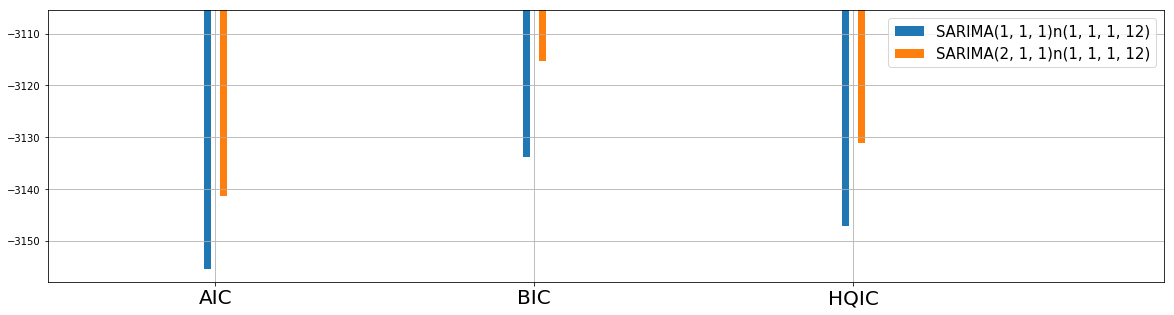

In [18]:
labels = ['SARIMA(1, 1, 1)n(1, 1, 1, 12)',
          'SARIMA(2, 1, 1)n(1, 1, 1, 12)']


plt.figure(figsize=(20,5))
params = {'legend.fontsize': 15,
          'legend.handlelength': 2}
plt.rcParams.update(params)
spacing = 0.05
barWidth = 0.025
r = np.arange(3) - ((len(labels)/2)-1)*spacing

for i in np.arange(len(labels)):
    plt.bar(r, df_IC.loc[labels[i]].values, width=barWidth, edgecolor='white', label=labels[i])
    r = [x + spacing for x in r]
 
plt.xticks([r + barWidth for r in range(3)], ['AIC', 'BIC', 'HQIC'], fontsize='20')
plt.axis((-0.5, 3.0, min(df_IC.min())-0.05*(max(df_IC.max())-min(df_IC.min())), max(df_IC.max())+0.05*(max(df_IC.max())-min(df_IC.min()))))
plt.legend(loc='best')
plt.grid()
plt.show()

## Selected Models Cross-Validation
    Although IC provides an estimate of the quality of each model, relative to each of the other models. It does so by analyzing the models itself, and not having a look into the data. Another raised question is, which IC should be followed in this case.
    By applying cross-validation and having a look at the data itself, and the model, simultaneously. It will be possible to estimate the prediction performance, but also, which model is the most likely to perform better with un-seen data.

In [19]:
labels = ['SARIMA(1, 1, 1)n(1, 1, 1, 12)',
          'SARIMA(2, 1, 1)n(1, 1, 1, 12)']

# Select data to be used for cross-validation
Xcv, ycv = splitTrain.split_train_variableInput(sequence = df_Train.values[-240:], 
                                                minSamplesTrain = 200, 
                                                numOutputs = stepsToForecast[-1], 
                                                numJumps = 4)


dict_MAE = {} 
for model_str in labels:
    list_conv = list()
    list_mae = list()
    list_mape = list()
    print("%s" % model_str);
    for i in np.arange(len(Xcv)):
        try:
            model = SARIMAX(Xcv[i], order=parse_tuple(model_str[6:15]), \
                                    trend=model_str[15],     \
                                    seasonal_order=parse_tuple(model_str[16:]));
            model_fit = model.fit(disp=0);

            if (~np.isnan(model_fit.mle_retvals.get('fopt'))):
                if (isLog):
                    predictions_array = np.e**(model_fit.forecast(steps=stepsToForecast[-1])[0]);
                else:
                    predictions_array = model_fit.forecast(steps=stepsToForecast[-1])[0];

                list_conv.append(i+1)

                mae = horizon_mae(ycv[i], predictions_array, stepsToForecast)
                list_mae.append(mae)

                mape = horizon_mape(ycv[i], predictions_array, stepsToForecast)
                list_mape.append(mape)

                print("%d/%d" % (i+1, len(Xcv)));
        except:
            continue
    print("")

    dict_MAE[model_str] =  {'conv': list_conv, 'mae': list_mae, 'mape': list_mape}  

AttributeError: module 'TimeSeriesCrossValidation.splitTrain' has no attribute 'split_train_variableInput'

In [ ]:
labels = ['SARIMA(1, 1, 1)n(1, 1, 1, 12)',
          'SARIMA(2, 1, 1)n(1, 1, 1, 12)']

# Select index of stepsToForecast to assess cross-validation from
PRED_IX = 3


plt.figure(figsize=(20,5));
for model_str in labels:
    plt.plot(dict_MAE[model_str]['conv'], [mae[PRED_IX-1] for mae in dict_MAE[model_str]['mae']], 'o', markersize=10)
plt.legend(labels)
plt.xlabel('# RUNS')
plt.ylabel('Mean Absolute Error')
plt.title('Mean Absolute Error at each Cross-Validation run')
if (len(Xcv) > 500):
    plt.xticks(np.arange(0, len(Xcv), 100))
if (len(Xcv) > 250):
    plt.xticks(np.arange(0, len(Xcv), 50))
elif (len(Xcv) > 50):
    plt.xticks(np.arange(0, len(Xcv), 10))
else:
    plt.xticks(np.arange(1,len(Xcv)+1))
plt.xlim([0, len(Xcv)+1])
plt.grid()
plt.show();

plt.figure(figsize=(20, 5))
y_bp = []
x_bp = np.empty((0))
for model_str in labels:
    if (len(dict_MAE[model_str]['conv'])>0):
        maeVals = [mae[PRED_IX-1] for mae in dict_MAE[model_str]['mae']]
        y_bp.extend(maeVals)
        x_bp = np.append(x_bp, np.repeat(model_str, len(maeVals)))
        df_bp = pd.DataFrame(data={'SARIMA Model': x_bp, 'Mean Average Error': y_bp})
bplot=sns.boxplot(y='Mean Average Error', x='SARIMA Model', data=df_bp, width=0.5) 
plt.title('Boxplot of Mean Absolute Error of Cross-Validation associated with each ARIMA model');
plt.grid(linewidth=.3)
plt.show();

for i in np.arange(len(labels)):
    if (len(dict_MAE[labels[i]]['conv'])>0):
        print(labels[i])
        print('Prediction for ' + str(stepsToForecast[PRED_IX-1]) + ' ' + xlab + ': MAE = ' \
              + str(round(np.mean([mae[PRED_IX-1] for mae in dict_MAE[labels[i]]['mae']]), 2)) \
              + ' (' + str(round(np.mean([mape[PRED_IX-1] for mape in dict_MAE[labels[i]]['mape']]), 2)) + '%)' )

# Model Validation
    This section allows to validate the selected model

In [ ]:
# Pick you favourite's models order
order = (2, 1, 1)
trend = 'n'
seasonal_order= (1, 1, 1, 12)

model = SARIMAX(df_Train.values, order=order, trend=trend, seasonal_order=seasonal_order)
model_fit = model.fit(disp=0);
df_res = pd.DataFrame({"resid": model_fit.resid}, index= df_Train.index)
model_fit.summary()

## Model Residual Analysis
    Plots residual and its histogram.
    
    Clearly there are outliers at the beggining, in order to not interfere with our residual analysis we will find these with an IQR algorithm applied at the beggining of the time series and replaced them by 0

In [ ]:
# Plot model residuals
plt.figure(figsize=(20,5))
plt.plot(df_res.index, df_res.values)
plt.xlabel(xlab)
plt.title('SARIMA' + str(order) + trend + str(seasonal_order) + ' Residuals')
plt.grid()
plt.show()

In [ ]:
df_resNew, outliers = replace_initial_outliers(df_res, seasonal_periods*5, 0, 3.5)

print("The following plot results from the residuals depicted above by replacing: ")
for key, value in outliers:
    print("%s: %.4f to 0.0000" % (key, value));

plt.figure(figsize=(20,5))
plt.plot(df_resNew.index, df_resNew.values)
plt.xlabel(xlab)
plt.ylabel(ylab)
plt.title('SARIMA' + str(order) + trend + str(seasonal_order) + ' Residuals')
plt.grid()
plt.show()

In [ ]:
# Plot histogram
plt.figure(figsize=(20,5))
plt.title('SARIMA' + str(order) + trend + str(seasonal_order) + ' Residuals Histogram')
hist_res = df_resNew['resid'].hist(bins=50, normed=1, edgecolor='black')
df_resNew['resid'].plot(kind='kde', linewidth=2, linestyle='--')
plt.xlabel('Residuals')
limX = np.mean(df_resNew.values)+5*np.std(df_resNew.values);
plt.xlim((-limX, limX))
plt.grid()
plt.show()

print ("Mean: %.6f" % np.mean(df_resNew))
print ("Variance: %.6f" % np.var(df_resNew))

## Normality Test

### Kurtosis and Kurtosis Test
    Compute the kurtosis (Fisher or Pearson) of a dataset.
    Kurtosis is the fourth central moment divided by the square of the variance. If Fisher's definition is used, then 3.0 is subtracted from the result to give 0.0 for a normal distribution. If bias is False then the kurtosis is calculated using k statistics to eliminate bias coming from biased moment estimators

    Test whether a dataset has normal kurtosis.
    This function tests the null hypothesis that the kurtosis of the population from which the sample was drawn is that of the normal distribution: kurtosis = 3(n-1)/(n+1).

In [ ]:
k, kpval = kurtosistest(df_resNew['resid'].values)
kurtosis_val = kurtosis(df_resNew['resid'].values, fisher=True)
# If Fisher’s definition is used, then 3.0 is subtracted from the result to give 0.0 for a normal distribution.
print("Kurtosis Test")
print("Statistic: %.4f" % k)
print("p-value: %.4f" % kpval)
print("Kurtosis value: %.4f" % kurtosis_val)

### Skew and Skewness Test
    Compute the skewness of a data set.
    For normally distributed data, the skewness should be about 0. For unimodal continuous distributions, a skewness value > 0 means that there is more weight in the right tail of the distribution. The function `skewtest` can be used to determine if the skewness value is close enough to 0, statistically speaking.

    Test whether the skew is different from the normal distribution.
    This function tests the null hypothesis that the skewness of the population that the sample was drawn from is the same as that of a corresponding normal distribution.

In [ ]:
s, spval = skewtest(df_resNew['resid'].values)
skew_val = skew(df_resNew['resid'].values)
print("Skew Test")
print("Statistic: %.4f" % s)
print("p-value: %.4f" % spval) 
print("Skewness value: %.4f" % skew_val) 

### Jarque-Bera and Kolmogorov-Smirnov tests
    Tests for goodness of fit (previously mentioned)

In [ ]:
jb, jbpval= stats.jarque_bera(df_resNew['resid'].values)
print("Jarque-Bera Test")
print("Statistic: %.4f" % jb)
print("p-value: %.4f" % jbpval)

print(" ")

ks, kspval = stats.kstest(df_resNew['resid'].values, 'norm')
print("Kolmogorov-Smirnov Test")
print("Statistic: %.4f" % ks)
print("p-value: %.4f" % kspval) 

### Engle's Test for Autoregressive Conditional Heteroscedasticity (ARCH)

In [ ]:
lm, lmpval, fval, fpval = het_arch(df_resNew['resid'].values)
print("Lagrange multiplier Test")
print("LM Statistic: %.4f" % lm)
print("LM-Test p-value: %.4f" % lmpval)
print('')
print('fstatistic for F test')
print("F Statistic: %.4f" % fval)
print("F-Test p-value: %.4f" % fpval)

## Test for No Autocorrelation

### Brock–Dechert–Scheinkman test
    Calculate the BDS test statistic for independence of a time series

In [ ]:
result = bds(df_resNew['resid'].values, max_dim=6);
print("BDS Test")
print("Dim 2: z-static %.4f Prob %.4f" % (result[0][0], result[1][0]))
print("Dim 3: z-static %.4f Prob %.4f" % (result[0][1], result[1][1]))
print("Dim 4: z-static %.4f Prob %.4f" % (result[0][2], result[1][2]))
print("Dim 5: z-static %.4f Prob %.4f" % (result[0][3], result[1][3]))
print("Dim 6: z-static %.4f Prob %.4f" % (result[0][4], result[1][4]))

### Box-Pierce and Ljung-Box tests
    Ljung-Box and Box-Pierce statistic differ in their scaling of the autocorrelation function. Ljung-Box test is reported to have better small sample properties.

In [ ]:
maxLags = 21
lbvalue, pvalue, bpvalue, bppvalue = acorr_ljungbox(df_res['resid'].values, lags = range(1, maxLags), boxpierce=True)

index = pd.MultiIndex.from_product([range(1, maxLags)], names=['lags'])
columns = pd.MultiIndex.from_product([['Box-Pierce', 'Ljung-Box'], ['Stats', 'p-value']], names=['Test', 'Statistics'])
data = np.array([bpvalue, bppvalue, lbvalue, pvalue])

boxTests = pd.DataFrame(data.T, index=index, columns=columns)
boxTests

### QQplot
    Q-Q plot of the quantiles of x versus the quantiles/ppf of a distribution.
    Can take arguments specifying the parameters for dist or fit them automatically.

In [ ]:
qqplot(df_resNew['resid'].values, stats.t, fit=True, line='45')
plt.title('QQ plot');
plt.grid()
plt.show()

### Plot Auto-correlation and Partial Auto-correlation functions
    Plots lags on the horizontal and the correlations on vertical axis.

In [ ]:
fig = plt.figure(figsize=(20,10))

# Auto-correlation function
ax1 = fig.add_subplot(221)
ax1.grid()
sm.graphics.tsa.plot_acf(df_resNew['resid'].values, lags=maxLags, ax=ax1)
ax2 = fig.add_subplot(222)
ax2.grid()
sm.graphics.tsa.plot_acf(df_resNew['resid'].values, lags=maxLags, ax=ax2, title = 'Zoom Autocorrelation')
ax2.axis((0, maxLags, -0.2, 0.2))

# Partial auto-correlation function
ax3 = fig.add_subplot(223)
ax3.grid()
sm.graphics.tsa.plot_pacf(df_resNew['resid'].values, lags=maxLags, ax=ax3);
ax4 = fig.add_subplot(224)
ax4.grid()
sm.graphics.tsa.plot_pacf(df_resNew['resid'].values, lags=maxLags, ax=ax4, title = 'Zoom Partial Autocorrelation')
ax4.axis((0, maxLags, -0.2, 0.2));

plt.show()

# Model Prediction       
    This section allows to see the forecast of the model that was selected and validated.

In [ ]:
dict_sarimaPred['SARIMA(2, 1, 1)n(1, 1, 1, 12)']

In [ ]:
dict_sarimaPred['SARIMA'+ str(order) + trend + str(seasonal_order)]

In [ ]:
cmap = plt.get_cmap("tab10")

plt.figure(figsize=(20,10))
plt.subplot(211)
plt.title('Real versus Predicted ' + ylab + ' for SARIMA' + str(order) + trend + str(seasonal_order))
plt.plot(range(0, stepsToForecast[-1]+1), np.concatenate((df_train.values[-1], df_test.values.flatten()), axis=0), 'k-o', linewidth=2)
plt.plot(range(1, stepsToForecast[-1]+1), dict_sarimaPred['SARIMA'+ str(order) + trend + str(seasonal_order)], color = cmap(0), linewidth=2)
plt.plot([0,1], [df_train.values[-1][0], dict_sarimaPred['SARIMA'+ str(order) + trend + str(seasonal_order)][0]], '--', color = cmap(0), linewidth=2)

plt.xlim([0,len(dict_sarimaPred['SARIMA'+ str(order) + trend + str(seasonal_order)])])
plt.xticks(np.arange(0, len(dict_sarimaPred['SARIMA'+ str(order) + trend + str(seasonal_order)])+1, step=1))
plt.grid(color='k', linestyle='--', linewidth=.5)
plt.xlabel(xlab)
plt.ylabel(ylab)
plt.legend(['Real value', 'Predicted value'])

plt.subplot(212)
plt.axhline(y=0, color='k', linestyle='--', linewidth=2)
plt.plot(range(0,stepsToForecast[-1]+1), np.concatenate((np.array([0]), df_test.values.flatten()-dict_sarimaPred['SARIMA'+ str(order) + trend + str(seasonal_order)]), axis=0), 'g-*', linewidth=2)
plt.xticks(np.arange(0, stepsToForecast[-1]+1, step=1))
plt.xlim([0, stepsToForecast[-1]])
plt.xlabel(xlab)
plt.ylabel('Prediction error')
plt.grid(color='k', linestyle='--', linewidth=.5)
plt.show()

for i in np.arange(len(labels[1:])):
    mae  = horizon_mae(df_test.values, dict_sarimaPred['SARIMA'+ str(order) + trend + str(seasonal_order)], stepsToForecast)
    mape = horizon_mape(df_test.values, dict_sarimaPred['SARIMA'+ str(order) + trend + str(seasonal_order)], stepsToForecast)
    print(labels[i+1])
    for i in np.arange(len(stepsToForecast)):
        print('Prediction for ' + str(stepsToForecast[i]) + ' ' + xlab + ': MAE = ' \
              + str(round(mae[i], 2)) + ' (' + str(round(mape[i], 2)) + '%)' )

In [ ]:
# Forecasted values of SARIMA model
dict_sarimaPred['SARIMA'+ str(order) + trend + str(seasonal_order)]

# Model Prediction (and comparison with others)
    Compare: Fitted values of the model with the training data
             Predicted values of the model with the testing data
             
    This section allows to see the forecast of the model that was selected and validated.
    But also, to compare it against other models.

In [ ]:
labels = ['Real Closing price',
          'SARIMA(1, 1, 1)n(1, 1, 1, 12)',
          'SARIMA(2, 1, 1)n(1, 1, 1, 12)']


plt.figure(figsize=(20,7))
previousStepsToShow = 15;
plt.title(title + ' fitting and forecasting')
plt.plot(1+np.arange(stepsToForecast[-1]), df_test.values, 'k-o' , linewidth = 3 )
for i in np.arange(len(labels)-1):
    sarimaPlot = plt.plot(1+np.arange(stepsToForecast[-1]), dict_sarimaPred[labels[i+1]], '--*' , linewidth = 3, label = labels[i+1] )
    plt.plot(1+np.arange(previousStepsToShow)-previousStepsToShow, dict_sarimaFit[labels[i+1]][-previousStepsToShow:], '--' , linewidth = 2, color=sarimaPlot[0].get_color())
plt.legend(loc='upper left', framealpha=0.95)
plt.plot(1+np.arange(previousStepsToShow)-previousStepsToShow, df_train.values[-previousStepsToShow:], 'k', linewidth = 4 )
plt.grid(color='k', linestyle='--', linewidth=.2)
plt.xlim([1-previousStepsToShow,+stepsToForecast[-1]])
plt.xticks(1+np.arange(-previousStepsToShow, stepsToForecast[-1]))
plt.xlabel('Past and future samples')
plt.ylabel(ylab);
plt.show()

for i in np.arange(len(labels[1:])):
    mae  = horizon_mae(df_test.values, dict_sarimaPred[labels[i+1]], stepsToForecast)
    mape = horizon_mape(df_test.values, dict_sarimaPred[labels[i+1]], stepsToForecast)
    print(labels[i+1])
    for i in np.arange(len(stepsToForecast)):
        print('Prediction for ' + str(stepsToForecast[i]) + ' ' + xlab + ': MAE = ' \
              + str(round(mae[i], 2)) + ' (' + str(round(mape[i], 2)) + '%)' )
    print("")